In [1]:
# Create MNIST data arrays
%run ./generate_mnist_dataset.ipynb

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Preprocessing MNIST training data...


 18%|█▊        | 1780/10000 [00:00<00:00, 17796.50it/s]

Preprocessing MNIST training data...


100%|██████████| 10000/10000 [00:00<00:00, 18853.85it/s]


In [1]:
# Load and prepare the data

import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from training_data import DataCollection
from PIL import Image
from matplotlib import pyplot as plt

data_train = DataCollection()
data_test = DataCollection(train=False)

print("Train data length: {0}".format(len(data_train.data)))
print("Test data length: {0}".format(len(data_test.data)))
print("Img Shape: {0}".format(data_train.data[0].shape))
print("Number of Labels: {0}".format(data_train.no_labels))

100%|██████████| 10000/10000 [00:00<00:00, 356288.88it/s]


Train data length: 64558
Test data length: 13982
Img Shape: torch.Size([1, 32, 32])
Number of Labels: 11


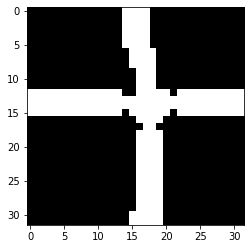

Label: 10


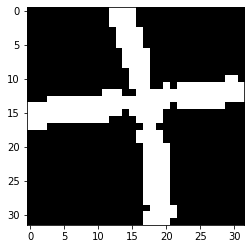

Label: 10


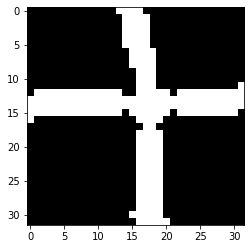

Label: 10


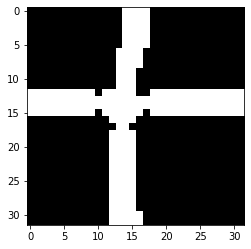

Label: 10


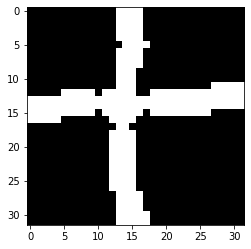

Label: 10


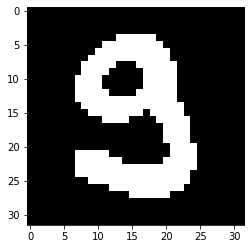

Label: 9


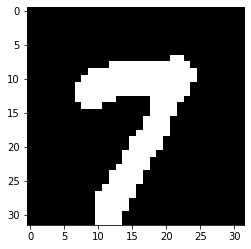

Label: 7


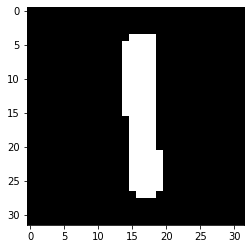

Label: 1


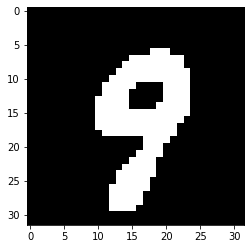

Label: 9


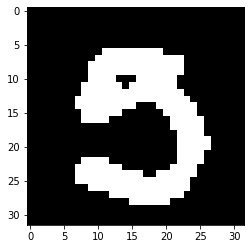

Label: 5


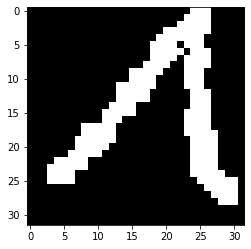

Label: 1


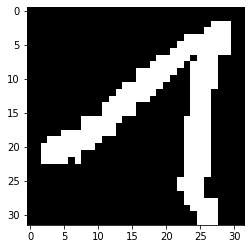

Label: 1


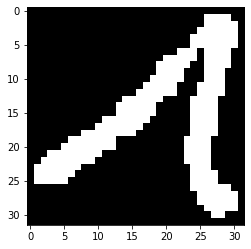

Label: 1


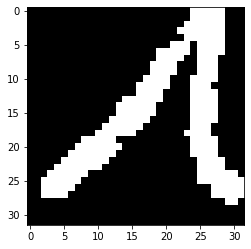

Label: 1


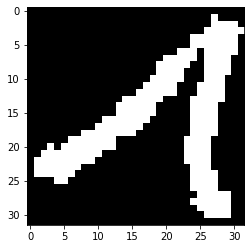

Label: 1


In [2]:
# Plot some images for control

from torchvision import transforms
for i in range(5):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])
for i in range(2000, 2005):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])
for i in range(61000, 61005):
    test_img = transforms.ToPILImage()(data_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_train.targets[i])

In [7]:
# Declare the network and some utilities

from torchvision import models
from torch.nn import Conv2d

pretrained = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch_model = models.alexnet(num_classes=15)
torch_model.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
if pretrained:
    torch_model.load_state_dict(torch.load('pretrained-model-01.ckpt'))
if torch.cuda.is_available():
    torch_model.to(device)
epochs = 11
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001, betas=(0.8, 0.99), weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

def calc_accuracy(model):
    accuracies = []
    for idx, [x_test, y_test] in enumerate(tqdm(test_loader)):
        if torch.cuda.is_available():
            x_test, y_test = x_test.to(device), y_test.to(device)
        test_pred = model(x_test)
        accuracy = 100 * torch.mean((torch.argmax(test_pred, dim=1) == y_test).float())
        accuracies.append(accuracy.item() if torch.cuda.is_available() else accuracy)
    return np.mean(accuracies)  

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=False)

print(torch_model)
print(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3):

In [8]:
for epoch in range(epochs):
    print("Epoch {0}".format(epoch))
    acc = calc_accuracy(torch_model)
    print("Accuracy: {0}".format(acc))
    if acc > 95:
        torch.save(torch_model.state_dict(), 'combined-model-{0}.ckpt'.format(acc))
    for step, [x_train, y_train] in enumerate(tqdm(train_loader)):
        if torch.cuda.is_available():
             x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        train_pred = torch_model(x_train)
        loss = criterion(train_pred, y_train)
        loss.backward()
        optimizer.step()
        if step % 500 == 0:
            print('Loss: {}'.format(loss))
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')

  3%|▎         | 29/874 [00:00<00:02, 283.27it/s]

Epoch 0


  0%|          | 4/4035 [00:00<01:49, 36.83it/s]

Accuracy: 8.904053616032721
Loss: 2.707108736038208


 13%|█▎        | 508/4035 [00:15<01:45, 33.48it/s]

Loss: 1.2031679153442383


 25%|██▍       | 1008/4035 [00:30<01:30, 33.44it/s]

Loss: 0.08878861367702484


 37%|███▋      | 1508/4035 [00:45<01:15, 33.45it/s]

Loss: 0.1658138930797577


 50%|████▉     | 2008/4035 [01:00<01:00, 33.40it/s]

Loss: 0.13186891376972198


 62%|██████▏   | 2508/4035 [01:15<00:46, 33.17it/s]

Loss: 0.007794111967086792


 75%|███████▍  | 3008/4035 [01:30<00:30, 33.24it/s]

Loss: 0.03664352744817734


 87%|████████▋ | 3508/4035 [01:45<00:15, 33.57it/s]

Loss: 0.01921066641807556


 99%|█████████▉| 4008/4035 [02:01<00:00, 33.16it/s]

Loss: 0.021605759859085083


  3%|▎         | 28/874 [00:00<00:03, 276.01it/s]

Epoch 1


  0%|          | 5/4035 [00:00<01:42, 39.29it/s]

Accuracy: 97.98340961098398
Loss: 0.027698054909706116


 13%|█▎        | 506/4035 [00:15<01:45, 33.47it/s]

Loss: 0.2987990379333496


 25%|██▍       | 1006/4035 [00:30<01:31, 32.95it/s]

Loss: 0.8405944108963013


 37%|███▋      | 1506/4035 [00:45<01:17, 32.74it/s]

Loss: 0.3128170967102051


 50%|████▉     | 2006/4035 [01:01<01:05, 31.05it/s]

Loss: 0.12350418418645859


 62%|██████▏   | 2506/4035 [01:16<00:45, 33.62it/s]

Loss: 0.079843670129776


 74%|███████▍  | 3006/4035 [01:31<00:30, 33.59it/s]

Loss: 0.08501822501420975


 87%|████████▋ | 3506/4035 [01:46<00:15, 33.55it/s]

Loss: 0.0015356242656707764


 99%|█████████▉| 4006/4035 [02:01<00:00, 32.09it/s]

Loss: 0.0049009770154953


  3%|▎         | 28/874 [00:00<00:03, 273.31it/s]

Epoch 2


100%|██████████| 874/874 [00:02<00:00, 340.12it/s]


Accuracy: 98.26229977116705


  0%|          | 4/4035 [00:00<01:57, 34.32it/s]

Loss: 0.004126071929931641


 13%|█▎        | 508/4035 [00:15<01:44, 33.59it/s]

Loss: 0.13558511435985565


 25%|██▍       | 1008/4035 [00:30<01:38, 30.63it/s]

Loss: 0.0007266849279403687


 37%|███▋      | 1508/4035 [00:45<01:15, 33.58it/s]

Loss: 0.01914813369512558


 50%|████▉     | 2008/4035 [01:00<01:00, 33.55it/s]

Loss: 0.03776150941848755


 62%|██████▏   | 2504/4035 [01:15<00:46, 33.22it/s]

Loss: 0.009613081812858582


 74%|███████▍  | 3006/4035 [01:30<00:30, 33.29it/s]

Loss: 0.041435763239860535


 87%|████████▋ | 3506/4035 [01:45<00:16, 32.93it/s]

Loss: 0.0012393295764923096


 99%|█████████▉| 4006/4035 [02:00<00:00, 33.52it/s]

Loss: 0.0004392266273498535


  3%|▎         | 28/874 [00:00<00:03, 274.50it/s]

Epoch 3


  0%|          | 4/4035 [00:00<01:44, 38.53it/s]

Accuracy: 98.26945080091534
Loss: 0.005641549825668335


 13%|█▎        | 507/4035 [00:15<01:45, 33.54it/s]

Loss: 0.24993042647838593


 25%|██▍       | 1007/4035 [00:29<01:30, 33.54it/s]

Loss: 0.1419840306043625


 37%|███▋      | 1507/4035 [00:44<01:15, 33.51it/s]

Loss: 2.8640031814575195e-05


 50%|████▉     | 2007/4035 [00:59<01:00, 33.57it/s]

Loss: 0.0023244470357894897


 62%|██████▏   | 2507/4035 [01:14<00:45, 33.53it/s]

Loss: 0.09982530772686005


 75%|███████▍  | 3007/4035 [01:29<00:30, 33.56it/s]

Loss: 0.25564587116241455


 87%|████████▋ | 3507/4035 [01:44<00:15, 33.58it/s]

Loss: 0.0035183727741241455


 99%|█████████▉| 4007/4035 [01:59<00:00, 33.34it/s]

Loss: 0.014365673065185547


  3%|▎         | 27/874 [00:00<00:03, 269.29it/s]

Epoch 4


  0%|          | 5/4035 [00:00<01:42, 39.28it/s]

Accuracy: 96.875
Loss: 0.16724607348442078


 13%|█▎        | 506/4035 [00:15<01:45, 33.36it/s]

Loss: 0.39689263701438904


 25%|██▍       | 1006/4035 [00:30<01:41, 29.87it/s]

Loss: 0.011761322617530823


 37%|███▋      | 1506/4035 [00:45<01:15, 33.56it/s]

Loss: 0.004373654723167419


 50%|████▉     | 2004/4035 [01:00<01:07, 30.11it/s]

Loss: 0.08368793874979019


 62%|██████▏   | 2508/4035 [01:15<00:46, 33.05it/s]

Loss: 0.00449196994304657


 75%|███████▍  | 3008/4035 [01:30<00:30, 33.52it/s]

Loss: 0.23443201184272766


 87%|████████▋ | 3508/4035 [01:45<00:15, 33.56it/s]

Loss: 0.016737572848796844


 99%|█████████▉| 4008/4035 [02:00<00:00, 33.57it/s]

Loss: 0.08834591507911682


  3%|▎         | 27/874 [00:00<00:03, 269.67it/s]

Epoch 5


  0%|          | 5/4035 [00:00<01:41, 39.79it/s]

Accuracy: 98.80577803203661
Loss: 0.16139006614685059


 13%|█▎        | 506/4035 [00:15<01:44, 33.62it/s]

Loss: 0.00011938810348510742


 25%|██▍       | 1006/4035 [00:30<01:30, 33.36it/s]

Loss: 0.0027766525745391846


 37%|███▋      | 1508/4035 [00:45<01:15, 33.48it/s]

Loss: 0.6774489879608154


 50%|████▉     | 2008/4035 [01:00<01:00, 33.36it/s]

Loss: 0.0035138577222824097


 62%|██████▏   | 2508/4035 [01:15<00:45, 33.23it/s]

Loss: 0.1870107650756836


 75%|███████▍  | 3008/4035 [01:30<00:31, 33.09it/s]

Loss: 0.018704839050769806


 87%|████████▋ | 3508/4035 [01:45<00:15, 33.60it/s]

Loss: 0.25562769174575806


 99%|█████████▉| 4008/4035 [02:00<00:00, 33.29it/s]

Loss: 0.0009583234786987305


  3%|▎         | 27/874 [00:00<00:03, 268.25it/s]

Epoch 6


  0%|          | 0/4035 [00:00<?, ?it/s]

Accuracy: 97.933352402746


  0%|          | 5/4035 [00:00<01:43, 39.06it/s]

Loss: 0.5212546586990356


 13%|█▎        | 506/4035 [00:15<01:45, 33.52it/s]

Loss: 0.0030461102724075317


 25%|██▍       | 1006/4035 [00:30<01:41, 29.92it/s]

Loss: 0.005563333630561829


 37%|███▋      | 1506/4035 [00:45<01:15, 33.37it/s]

Loss: 0.008118480443954468


 50%|████▉     | 2006/4035 [01:00<01:00, 33.38it/s]

Loss: 0.22946137189865112


 62%|██████▏   | 2506/4035 [01:15<00:45, 33.60it/s]

Loss: 0.03455276042222977


 74%|███████▍  | 3006/4035 [01:31<00:31, 32.70it/s]

Loss: 0.00629328191280365


 87%|████████▋ | 3506/4035 [01:47<00:15, 33.42it/s]

Loss: 0.0007065683603286743


 99%|█████████▉| 4006/4035 [02:02<00:00, 33.38it/s]

Loss: 0.001433730125427246


  3%|▎         | 27/874 [00:00<00:03, 268.93it/s]

Epoch 7


  0%|          | 5/4035 [00:00<01:43, 38.76it/s]

Accuracy: 98.3695652173913
Loss: 0.5834861397743225


 13%|█▎        | 506/4035 [00:15<01:45, 33.56it/s]

Loss: 5.614757537841797e-05


 25%|██▍       | 1006/4035 [00:30<01:30, 33.42it/s]

Loss: 0.0010657012462615967


 37%|███▋      | 1506/4035 [00:45<01:15, 33.39it/s]

Loss: 0.0009916424751281738


 50%|████▉     | 2006/4035 [01:00<01:00, 33.42it/s]

Loss: 0.00027933716773986816


 62%|██████▏   | 2506/4035 [01:15<00:47, 31.96it/s]

Loss: 0.0018962621688842773


 74%|███████▍  | 3006/4035 [01:30<00:32, 31.25it/s]

Loss: 0.018700718879699707


 87%|████████▋ | 3506/4035 [01:45<00:16, 32.66it/s]

Loss: 0.8081424832344055


 99%|█████████▉| 4006/4035 [02:02<00:00, 30.19it/s]

Loss: 0.05953528732061386


  3%|▎         | 28/874 [00:00<00:03, 277.93it/s]

Epoch 8


  0%|          | 4/4035 [00:00<01:42, 39.31it/s]

Accuracy: 98.57694508009153
Loss: 0.008011981844902039


 13%|█▎        | 508/4035 [00:15<01:44, 33.64it/s]

Loss: 0.6372405290603638


 25%|██▍       | 1004/4035 [00:30<01:40, 30.10it/s]

Loss: 0.8401408195495605


 37%|███▋      | 1508/4035 [00:45<01:15, 33.61it/s]

Loss: 0.0016963332891464233


 50%|████▉     | 2004/4035 [01:01<01:07, 30.17it/s]

Loss: 0.5188330411911011


 62%|██████▏   | 2508/4035 [01:17<00:46, 33.14it/s]

Loss: 0.00010940432548522949


 75%|███████▍  | 3008/4035 [01:32<00:30, 33.32it/s]

Loss: 0.0017571449279785156


 87%|████████▋ | 3508/4035 [01:47<00:15, 33.64it/s]

Loss: 0.02886618673801422


 99%|█████████▉| 4008/4035 [02:02<00:00, 33.56it/s]

Loss: 0.30498892068862915


  3%|▎         | 28/874 [00:00<00:03, 275.31it/s]

Epoch 9


100%|██████████| 874/874 [00:02<00:00, 343.58it/s]


Accuracy: 98.80577803203661


  0%|          | 8/4035 [00:00<01:47, 37.59it/s]

Loss: 0.0003586113452911377


 13%|█▎        | 508/4035 [00:15<01:45, 33.57it/s]

Loss: 0.0007646679878234863


 25%|██▍       | 1008/4035 [00:29<01:30, 33.59it/s]

Loss: 0.00011831521987915039


 37%|███▋      | 1508/4035 [00:44<01:15, 33.60it/s]

Loss: 0.0009313523769378662


 50%|████▉     | 2008/4035 [00:59<01:00, 33.60it/s]

Loss: 0.052202075719833374


 62%|██████▏   | 2508/4035 [01:14<00:45, 33.62it/s]

Loss: 0.6090572476387024


 75%|███████▍  | 3008/4035 [01:29<00:30, 33.57it/s]

Loss: 0.003681480884552002


 87%|████████▋ | 3508/4035 [01:44<00:15, 33.57it/s]

Loss: 0.001784682273864746


 99%|█████████▉| 4008/4035 [01:59<00:00, 33.57it/s]

Loss: 0.17795512080192566


  3%|▎         | 28/874 [00:00<00:03, 274.83it/s]

Epoch 10


  0%|          | 5/4035 [00:00<01:45, 38.31it/s]

Accuracy: 98.6413043478261
Loss: 0.001973256468772888


 13%|█▎        | 506/4035 [00:15<01:44, 33.77it/s]

Loss: 0.003511980175971985


 25%|██▍       | 1006/4035 [00:29<01:30, 33.59it/s]

Loss: 0.471407949924469


 37%|███▋      | 1506/4035 [00:44<01:15, 33.60it/s]

Loss: 0.12707777321338654


 50%|████▉     | 2006/4035 [00:59<01:00, 33.61it/s]

Loss: 0.05238492786884308


 62%|██████▏   | 2506/4035 [01:14<00:45, 33.59it/s]

Loss: 0.0030967742204666138


 74%|███████▍  | 3006/4035 [01:29<00:30, 33.59it/s]

Loss: 0.0013914704322814941


 87%|████████▋ | 3506/4035 [01:44<00:15, 33.60it/s]

Loss: 0.05904339998960495


 99%|█████████▉| 4006/4035 [01:59<00:00, 33.61it/s]

Loss: 0.012319788336753845


100%|██████████| 874/874 [00:02<00:00, 345.56it/s]

Accuracy: 98.3266590389016


In [ ]:
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')